In [1]:
#Projekt Bartłomiej Noga, Aleksander Gągorowski
#https://www.kaggle.com/c/dogs-vs-cats/data Link do bazy danych
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir('C:/Users/Porkens/dogs-vs-cats'))

['sampleSubmission.csv', 'test1', 'test1.zip', 'train', 'train.zip']


In [2]:
FAST_RUN = False
IMAGE_WIDTH=64
IMAGE_HEIGHT=64
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
filenames = os.listdir('C:/Users/Porkens/dogs-vs-cats/train/train') #ścieżka plików z której algorytm będzie pobierał dane
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
#Rozdzielamy zdjęcia na dwie kategorie, 1 przypisujemy dla psów a 0 dla kotów.
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df.head()#Początek bazy

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [5]:
df.tail()#Koniec bazy

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


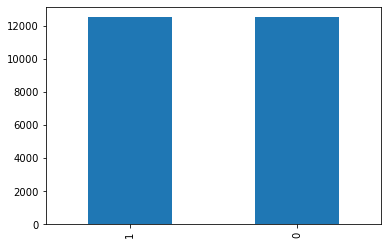

In [6]:
df['category'].value_counts().plot.bar()#Ilość plików dla danych kategorii

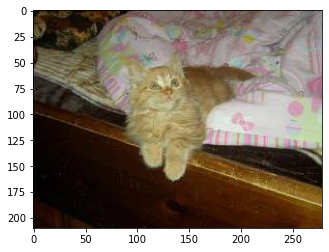

In [7]:
sample = random.choice(filenames)
image = load_img("C:/Users/Porkens/dogs-vs-cats/train/train/"+sample)
plt.imshow(image) #losowe zdjęcie z bazy danych 

In [8]:
from keras.models import Sequential #Używamy modelu sekwencyjnego dla zwykłego stosu warstw 
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))) #32 filtry 
model.add(BatchNormalization()) #Autoamatyczna standardyzacja danych wejsciowych do warstwy sieci neurowej głębokiego uczenia.
model.add(MaxPooling2D(pool_size=(2, 2))) #Próbkowanie danych w dół, pobierając maksymalną wartość z okna zdefiniowanego przez 
#pool_size dla każdego wymiaru 
model.add(Dropout(0.25)) #Dropout to technika, w której losowo wybrane neurony są ignorowne podczas treningu, tutaj oznacza to
#że 25% danych jest ignorowanie podczas uczenia.
#Pierwszym paramerem Conv2D jest liczba filtrów których nauczy się warstwa konwolicyjna.Zazwyczaj używa się tutaj potęgi liczby 2
#Drugim parametrem który musimy podać Conv2D to jest rozmiar kernela, określa ona szerokość i wysokość okna splotu, u nas ona
#wynosi 3, 3.
model.add(Conv2D(64, (3, 3), activation='relu')) #64 filtry
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu')) #ostatnia warstwa posiada 128 filtrów 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu')) #Gęstość sieci, czyli ile nueonów jest połączonych z każdym w następnej warstwie.
model.add(BatchNormalization())#Normalizujemy dane aby przyspeszyć procses trenowania sieci .
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 warstwy ponieważ mamy psy i koty.

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [10]:


earlystop = EarlyStopping(patience=10)

#Earlystop, aby w razie wypadku zatzrymać uczenie gdy by nie przynosiło skutków.

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
#zmniejszamy współczynnik uczenia się, gdy wskaźniok przestał się poprawiać. 
#monitor to ilośc do monitorowania, patience to liczba epok bez poprawy po których tempo uczenia się zmniejszy
#verbose to aktualizacja postępu, factor jest to współczynnik zmninejszenie się uczenia, min_lr to dolna granica szybkości
#uczenia się

In [12]:
callbacks = [earlystop, learning_rate_reduction]

In [13]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [14]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42) #train_df przechowuje nasze dane szkoleniowe
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

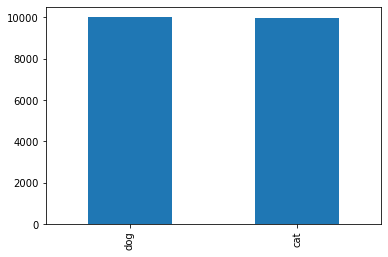

In [15]:
train_df['category'].value_counts().plot.bar()#Ilość danych szkoloeniowych

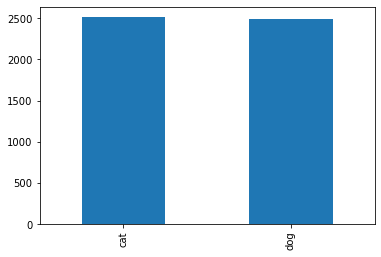

In [16]:
validate_df['category'].value_counts().plot.bar()#Ilość danych validacyjnych

In [17]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15 #losujemy 15 zdjęć 

In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1#Parametry zmiany wylosowanego zdjęcia
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "C:/Users/Porkens/dogs-vs-cats/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [19]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "C:/Users/Porkens/dogs-vs-cats/test1/test1/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)#Kategoryzowanie wylosowanych zdjęć 

Found 5000 validated image filenames belonging to 2 classes.


In [20]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "C:/Users/Porkens/dogs-vs-cats/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


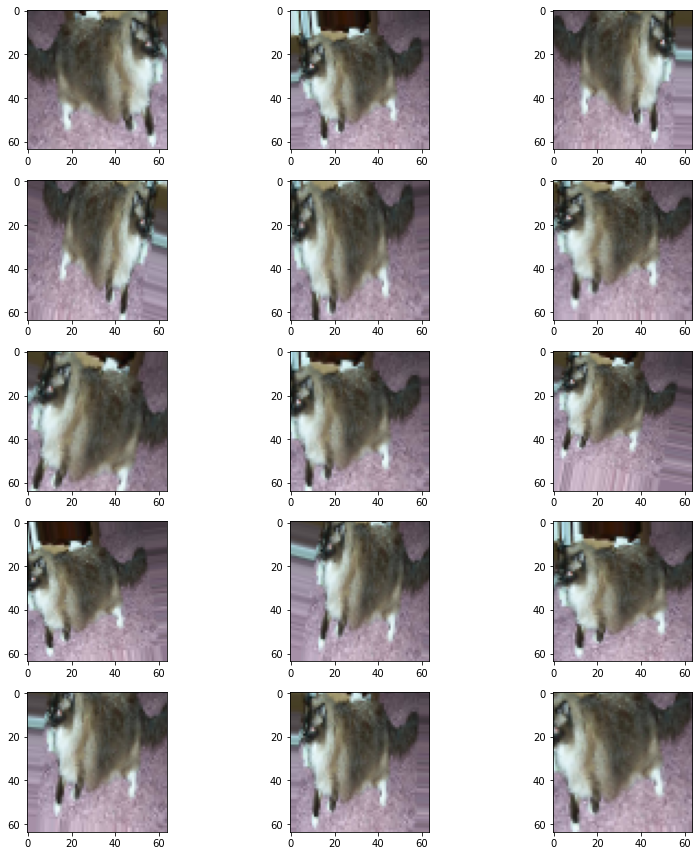

In [21]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()
#W wyszych linijkach wybieramy losowo jedno zdjęcie które będzie losowo edytowane przez algorytm

In [22]:
epochs=100 if FAST_RUN else 100 
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)#Tutaj wykonujemy uczenie się algorytmu na podstawie bazy

Epoch 1/100
1333/1333 [==============================] - 208s 155ms/step - loss: 0.9343 - accuracy: 0.5814 - val_loss: 0.6882 - val_accuracy: 0.6234
Epoch 2/100
1333/1333 [==============================] - 199s 149ms/step - loss: 0.5932 - accuracy: 0.6941 - val_loss: 0.5219 - val_accuracy: 0.7395
Epoch 3/100
1333/1333 [==============================] - 210s 158ms/step - loss: 0.5520 - accuracy: 0.7295 - val_loss: 0.4855 - val_accuracy: 0.7632
Epoch 4/100
1333/1333 [==============================] - 204s 153ms/step - loss: 0.5050 - accuracy: 0.7597 - val_loss: 0.9467 - val_accuracy: 0.6382
Epoch 5/100
1333/1333 [==============================] - 531s 399ms/step - loss: 0.5056 - accuracy: 0.7588 - val_loss: 0.5482 - val_accuracy: 0.7447

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/100
1333/1333 [==============================] - 753s 565ms/step - loss: 0.4498 - accuracy: 0.7895 - val_loss: 0.3592 - val_accuracy: 0.8432
Epoch 7/100
1333/1333 [==

In [23]:
model.save_weights("model.h5")

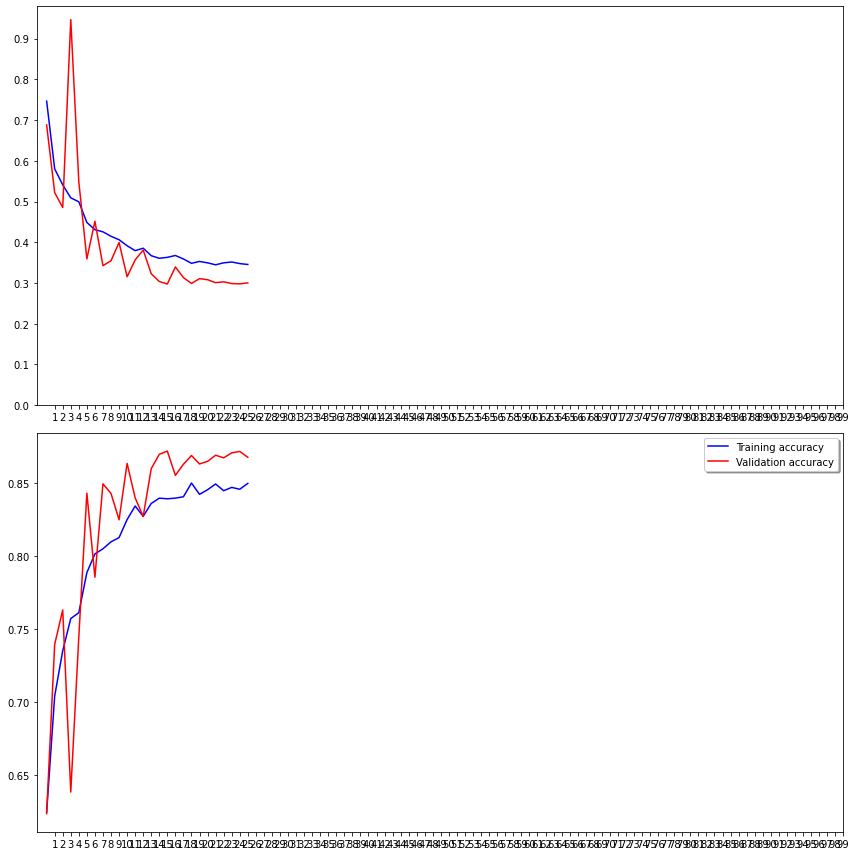

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
#Wyświetlenie modelu szybkości uczenia się i celności predykcji zdjęć
legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [25]:
test_filenames = os.listdir("C:/Users/Porkens/dogs-vs-cats/test1/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
#Wybranie scieżki dla plików testowych

In [26]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "C:/Users/Porkens/dogs-vs-cats/test1/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 3044 validated image filenames.


In [27]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

C:\Users\Porkens\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [28]:
test_df['category'] = np.argmax(predict, axis=-1)

In [29]:


label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)



In [30]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

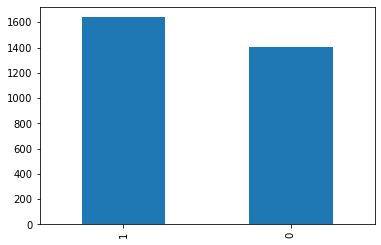

In [31]:


test_df['category'].value_counts().plot.bar()
#Przedstawienie ilości plików testowych


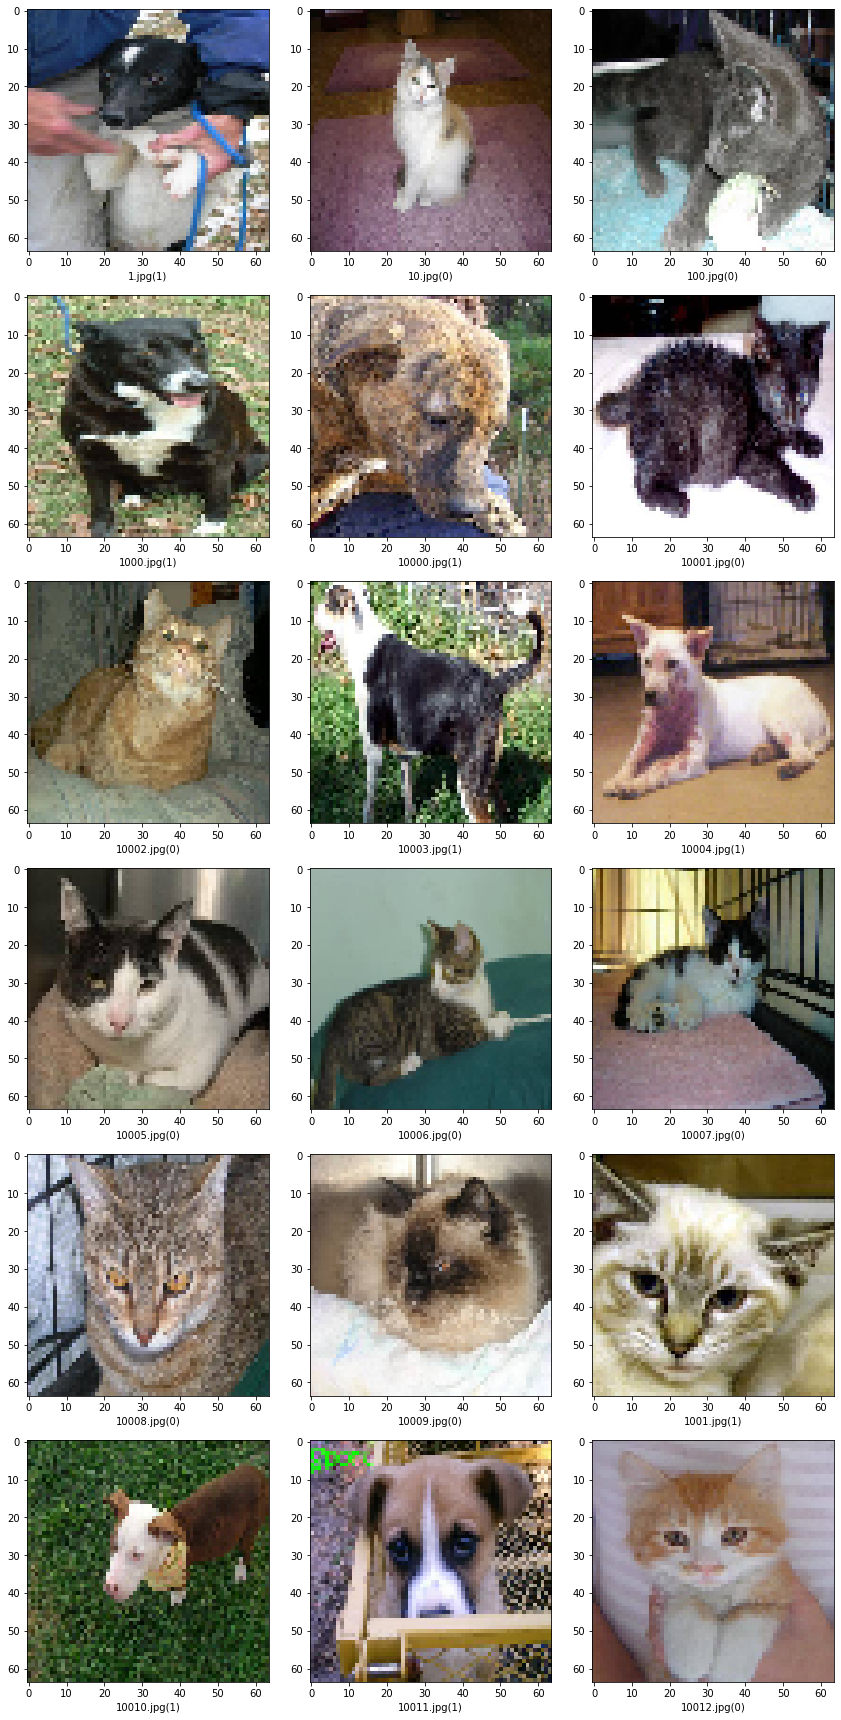

In [32]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("C:/Users/Porkens/dogs-vs-cats/test1/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()
#Przedstawienie wyniku działana programu

In [33]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)